# **Hotel Booking Cancellation Prediction Project**

## Business Context

With the increasing popularity and ease-of-access of online hotel booking platforms, customers tend to make reservations in advance to avoid any last minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations becomes a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

1. Loss of revenue when the hotel cannot resell the room

2. Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

3. Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition

The INN Hotels Group have been contending with the challenge of rising cancellations for nearly a year now. However, the last three months seeing a **rise of inventory loss due to cancellation rise to an all-time high of 18%**. This has led to a jump in the **revenue loss to an all-time high of approx. \$0.25 million annually**. This has significantly impacted their profit margins.

- In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss

The group has been using heuristic mechanisms (rule and domain expert based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they **need an Data Science-based solution to predict the likelihood of a booking being cancelled** as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly **minimize revenue loss and improve operational efficiency**.


## Importing the necessary libraries

In [ ]:
# installing the library for deploying ML models
!pip install gradio

In [ ]:
# libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# removing the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# setting the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# setting the precision of floating numbers to 2 decimal points
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# library to split data
from sklearn.model_selection import train_test_split

# library to build ML model
from sklearn.tree import DecisionTreeClassifier

# library to tune ML model
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# libraries to evaluate the ML model
from sklearn.metrics import f1_score, make_scorer

# libraries to deploy the ML model
import os
import joblib
import gradio as gr

## Loading the dataset

In [ ]:
# # importing using Google Colab

# # connecting Google Drive to this Python notebook
# from google.colab import drive
# drive.mount('/content/drive')

# # defining the location where the data is stored
# path = "/content/drive/MyDrive/"
# # loading the data into a Pandas dataframe
# # hotel = pd.read_csv(path+"INNHotelsGroup.csv")

In [ ]:
# # importing using Jupyter Notebook

# # loading the data into a Pandas dataframe
hotel = pd.read_csv("INNHotelsGroup.csv")

In [ ]:
hotel.sample(10, random_state=10)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
18212,103,Offline,0,115.00,1,0,2018-04-19,0,2,Canceled
3267,86,Online,2,90.00,2,1,2018-11-04,0,2,Not_Canceled
28472,20,Online,1,92.67,2,1,2018-12-09,0,2,Not_Canceled
34178,22,Online,1,126.04,2,4,2018-12-28,0,10,Not_Canceled
35404,109,Online,4,105.21,2,2,2018-07-06,0,4,Not_Canceled
31551,30,Offline,0,127.15,1,0,2018-10-28,0,1,Not_Canceled
30927,192,Offline,0,100.00,2,0,2018-08-25,0,3,Not_Canceled
30473,278,Online,0,103.95,2,2,2018-07-16,1,1,Canceled
27445,0,Online,0,85.93,1,0,2018-05-12,0,1,Not_Canceled
33154,37,Online,1,92.31,1,4,2018-12-15,0,9,Canceled


# **Exploratory Data Analysis**


In [ ]:
# creating a copy of the data to avoid any changes to original data
data = hotel.copy()

In [ ]:
# checking the statistical summary of the data
data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,36275.00,85.23,85.93,0.00,17.00,57.00,126.00,443.00
no_of_special_requests,36275.00,0.62,0.79,0.00,0.00,0.00,1.00,5.00
avg_price_per_room,36275.00,103.42,35.09,0.00,80.30,99.45,120.00,540.00
no_of_adults,36275.00,1.84,0.52,0.00,2.00,2.00,2.00,4.00
no_of_weekend_nights,36275.00,0.81,0.87,0.00,0.00,1.00,2.00,7.00
required_car_parking_space,36275.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
no_of_week_nights,36275.00,2.20,1.41,0.00,1.00,2.00,3.00,17.00


* The number of adults ranges from 0 to 4, which is usual.
* The range of the number of weeks and weekend nights seems fine. Though 7 weekends might be a very long stay.
* At least 75% of the customers do not require car parking space.
* On average the customers book 85 days in advance. There's also a very huge difference in 75th percentile and maximum value which indicates there might be outliers present in this column.
* The average price per room is 103 euros. There's a huge difference between the 75th percentile and the maximum value which indicates there might be outliers present in this column.

In [ ]:
# defining a function to create a bar graph with percentage values

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=15,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    # increase the size of x-axis and y-axis scales
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    # setting axis labels
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=15)
    ax.set_ylabel('')

    # show the plot
    plt.show()

In [ ]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(loc="upper left", fontsize=12, bbox_to_anchor=(1, 1))

    # setting the formatting for x-axis
    plt.xticks(fontsize=15, rotation=0)
    plt.xlabel(predictor.replace('_', ' ').title(), fontsize=15)
    # setting the formatting for y-axis
    plt.yticks(fontsize=15)
    # show the plot
    plt.show()

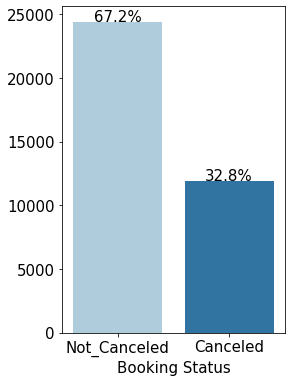

In [ ]:
# visualizing the number of cancelled bookings
labeled_barplot(data, "booking_status", perc=True)

- Approx. one-third of the bookings were canceled

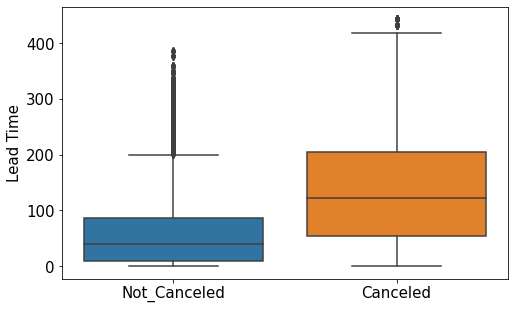

In [ ]:
# visualizing the relationship between lead time and booking cancellation
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="booking_status", y="lead_time")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Lead Time', fontsize=15);

- The higher the lead time, higher is the chances of cancellation

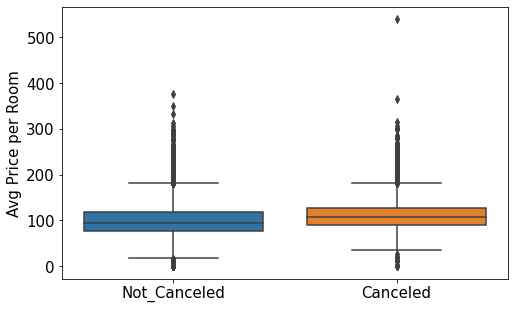

In [ ]:
# visualizing the relationship between avg room price and booking cancellation
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="booking_status", y="avg_price_per_room")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Avg Price per Room', fontsize=15);

- The booking status marginally varies with the average price per room

booking_status       Canceled  Not_Canceled    All
market_segment_type                               
Offline                  3153          7375  10528
Online                   8732         17015  25747
All                     11885         24390  36275
------------------------------------------------------------------------------------------------------------------------


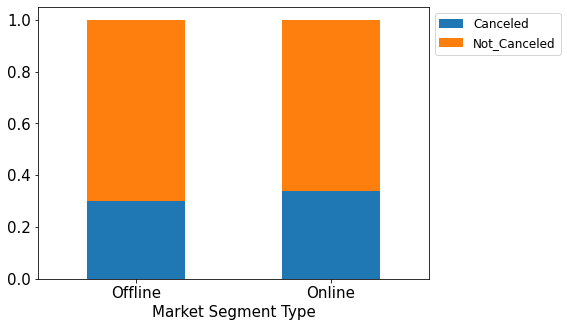

In [ ]:
stacked_barplot(data, "market_segment_type", "booking_status")

* Offline bookings have witnessed a slightly lower rate of cancellation compared to online bookings

In [ ]:
# converting the 'arrival_date' column to datetime type
data['arrival_date'] = pd.to_datetime(data['arrival_date'])

# extracting month from 'arrival_date'
data['arrival_month'] = data['arrival_date'].dt.month

In [ ]:
# grouping the data on arrival months and extracting the count of bookings
monthly_data = data.groupby(["arrival_month"])["booking_status"].count().to_frame().reset_index()
monthly_data.columns = ['Month', 'Bookings']
monthly_data

,Month,Bookings
0,1,1014
1,2,1704
2,3,2358
3,4,2736
4,5,2598
5,6,3203
6,7,2920
7,8,3813
8,9,4611
9,10,5317


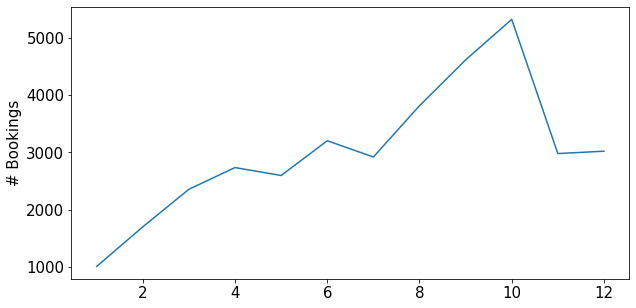

In [ ]:
# visualizing the trend of number of bookings across months
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_data, x="Month", y="Bookings")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('# Bookings', fontsize=15);

* The trend shows that the number of bookings rise from January to April, remain consistent from April to July, then rise again till October where it reaches a peak, and then drops down again in November and December

booking_status  Canceled  Not_Canceled    All
arrival_month                                
1                     24           990   1014
2                    430          1274   1704
3                    700          1658   2358
4                    995          1741   2736
5                    948          1650   2598
6                   1291          1912   3203
7                   1314          1606   2920
8                   1488          2325   3813
9                   1538          3073   4611
10                  1880          3437   5317
11                   875          2105   2980
12                   402          2619   3021
All                11885         24390  36275
------------------------------------------------------------------------------------------------------------------------


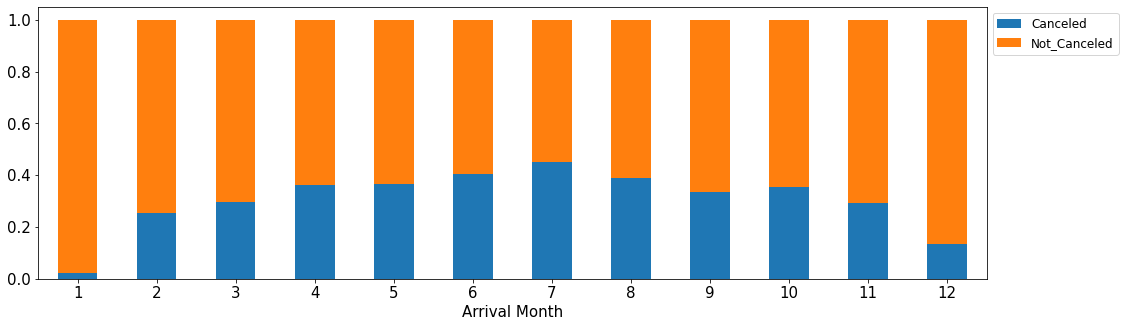

In [ ]:
##Let's check the percentage of bookings canceled in each month
stacked_barplot(data, "arrival_month", "booking_status")

* January and December witness a significantly lower rate of cancellation compared to the other months, and July witnesses the highest rate of cancellation

### EDA Summary

`Booking Status`


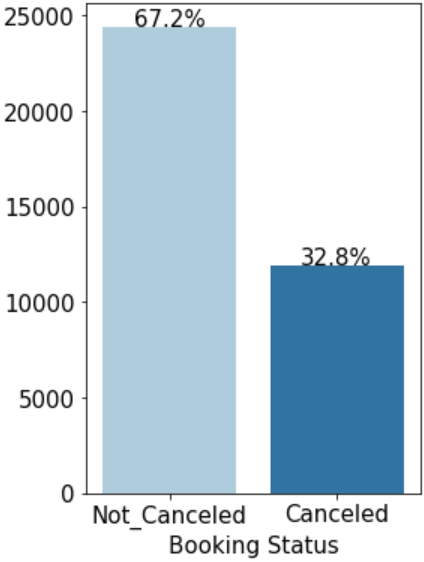



**Approx. one-third of the bookings were canceled**

`Lead Time Vs Booking Status`


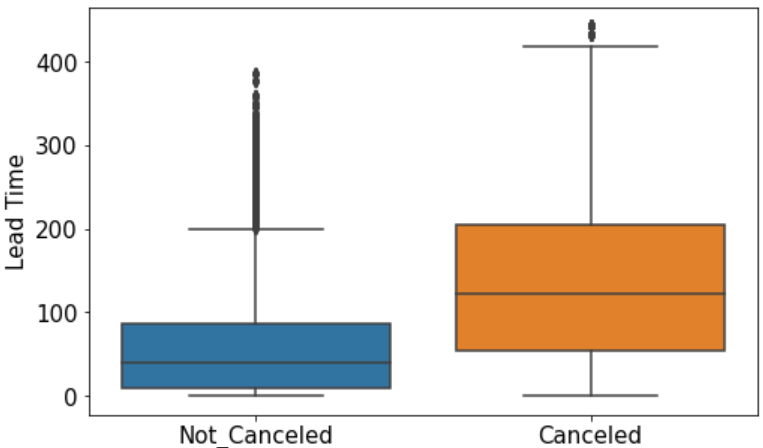

**The higher the lead time, higher is the chances of cancellation**

`Market Segment Type Vs Booking Status`

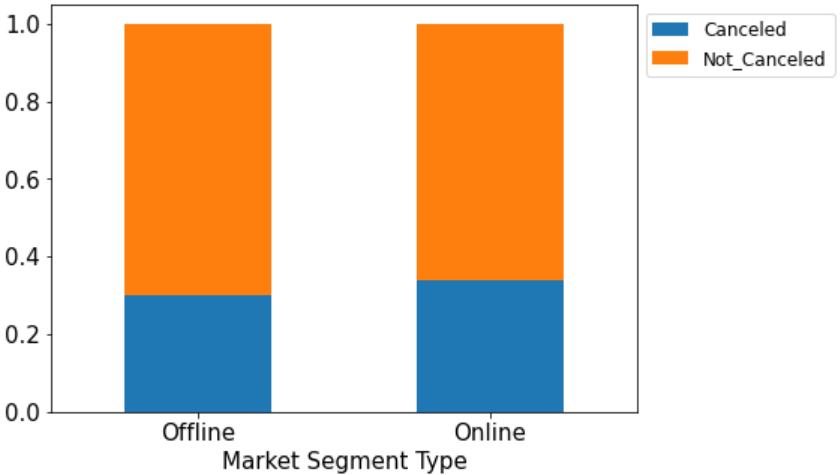

**The cancellation of bookings is independent of the mode of booking (online or offline)**

- Customers seem to behave similarly for both modes of booking, which might be due to flexible cancellation policy offered in either mode

`Arrival Month Vs Booking Status`

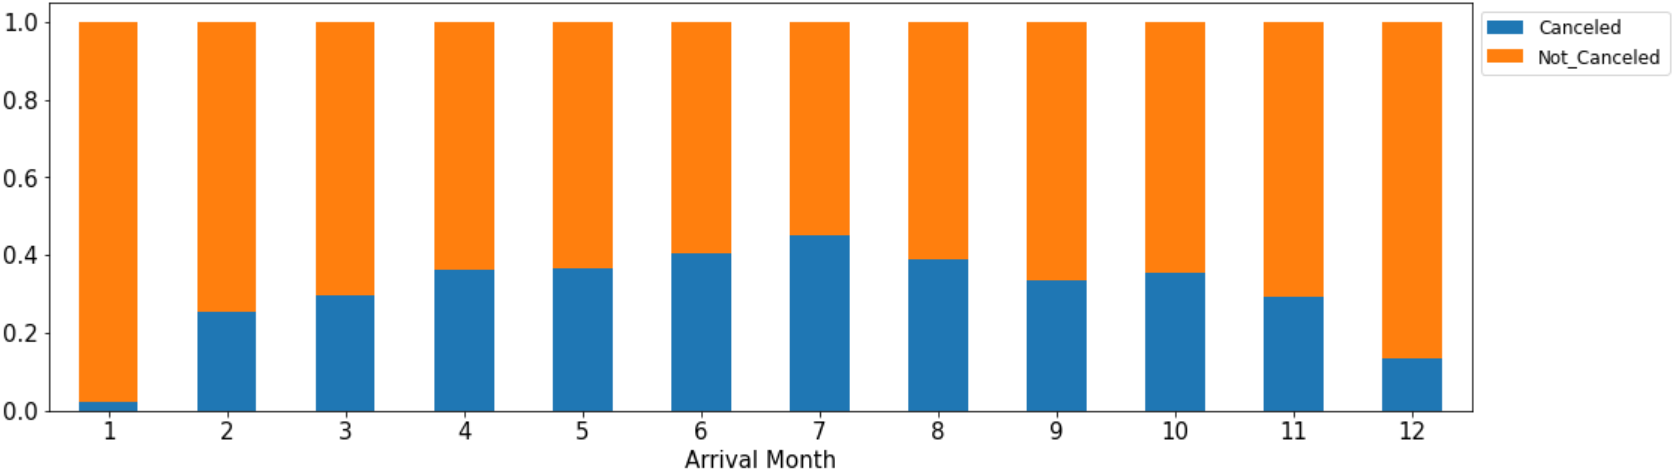

**January (\~2.5%) and December (\~10%) witness a significantly lower rate of cancellation compared to the other months (average \~30%), while July (~40%) witnesses the highest rate of cancellation**

We also noted the following based on the EDA conducted:

- **The booking status does not significantly vary with the average price per room**
- **The monthly booking trends show that the number of bookings rise from January to April, remain consistent from April to July, then rise again till October where it reaches a peak, and then drops down again in November and December**

We see that variables like lead time and arrival month have a fair amount of difference for cancelled and non-cancelled bookings, while some of the other variables like market segment and avg price per room do not. But we can only visualize the data in 2 or 3 dimensions, and there may be more complex relationships in the data beyond that which cannot be captured visually.

So, we need an ML model that can do the following:
  - Take the booking detail (customer arrival month, booking lead time, no. of guests, and more) as input
  - Learn the patterns in the input data
  - Fit a mathematical model using these patterns to identify which situations lead to booking cancellation
  - Predict the likelihood of cancellation of a new booking

# **Model Building**


## Data Preprocessing

In [ ]:
# encoding the output (also called target) attribute
data["booking_status"] = data["booking_status"].apply(
    lambda x: 1 if x == "Canceled" else 0
)

In [ ]:
# separating the input and output variables
X = data.drop(["booking_status","arrival_date"], axis=1)
y = data["booking_status"]

# encoding the categorical variables
X = pd.get_dummies(X, drop_first=True)

# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:
X.head()

,lead_time,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights,arrival_month,market_segment_type_Online
0,224,0,65.00,2,1,0,2,10,0
1,5,1,106.68,2,2,0,3,11,1
2,1,0,60.00,1,2,0,1,2,1
3,211,0,100.00,2,0,0,2,5,1
4,48,0,94.50,2,1,0,1,4,1


## Model Training and Evaluation

In [ ]:
# defining the ML model to build
model = DecisionTreeClassifier(random_state=1)

# training the ML model on the train data
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

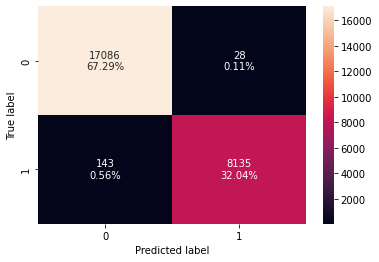

In [ ]:
# confusion matrix for train data
confusion_matrix_sklearn(model, X_train, y_train)

In [ ]:
# evaluating the model performance on the train data
model_train_predictions = model.predict(X_train)
model_train_score = f1_score(y_train, model_train_predictions)

print("Model Score on Train Data:", np.round(100*model_train_score, 2))

Model Score on Train Data: 98.96


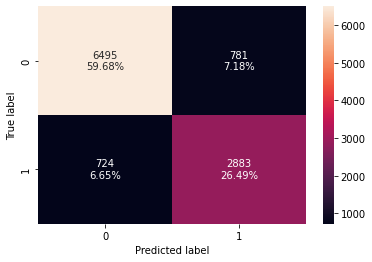

In [ ]:
# confusion matrix for test data
confusion_matrix_sklearn(model, X_test, y_test)

In [ ]:
# evaluating the model performance on the test data
model_test_predictions = model.predict(X_test)
model_test_score = f1_score(y_test, model_test_predictions)

print("Model Score on Test Data:", np.round(100*model_test_score, 2))

Model Score on Test Data: 79.3


## Observations from Model Evaluation

The ML model has a score of 99% on the train data and 79% on the test data respectively.

- This shows that while the model work really well on the data it is trained on, it fails to replicate the same performance on unseen data.

- This becomes a worry as the ultimate goal would be to make predictions for new reservations that have not come in yet, and we do not want a model that will fail to perform well on such unseen data.

## Model Tuning

In [ ]:
# choosing the type of ML Model
dummy_model = DecisionTreeClassifier(random_state=1, class_weight="balanced")

# defining the grid of parameters of the ML Model to choose from
parameters = {
    "max_leaf_nodes": [150, 250],
    "min_samples_split": [10, 30],
}

# defining the model score on which we want to compare parameter combinations
acc_scorer = make_scorer(f1_score)

# running the model tuning algorithm
grid_obj = GridSearchCV(dummy_model, parameters, scoring=acc_scorer, cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

In [ ]:
# selecting the best combination of parameters for the model to create a new model
tuned_model = grid_obj.best_estimator_

# training the new ML Model
tuned_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_leaf_nodes=250,
                       min_samples_split=10, random_state=1)

In [ ]:
# evaluating the model performance on the train data
tuned_model_train_predictions = tuned_model.predict(X_train)
tuned_model_train_score = f1_score(y_train, tuned_model_train_predictions)

print("Model Score on Train Data:", np.round(100*tuned_model_train_score, 2))

Model Score on Train Data: 81.83


In [ ]:
# evaluating the model performance on the test data
tuned_model_test_predictions = tuned_model.predict(X_test)
tuned_model_test_score = f1_score(y_test, tuned_model_test_predictions)

print("Model Score on Test Data:", np.round(100*tuned_model_test_score, 2))

Model Score on Test Data: 80.2


- The train and test performances are much more similar now, so we can say that the model is able to generalize well

## Model Testing

In [ ]:
final_model = tuned_model

In [ ]:
# evaluating the model performance on the test data
final_model_test_predictions = final_model.predict(X_test)
final_model_test_score = f1_score(y_test, final_model_test_predictions)

print("Model Score on Test Data:", np.round(100*final_model_test_score, 2))

Model Score on Test Data: 80.2


## Observations from Model Testing

- Our ML model has a score of ~80% on the test data, which is a good score.
- We can now move ahead to the next stage.

# **Model Deployment and Monitoring**

In [ ]:
# exporting the final model to the disk
joblib.dump(final_model, 'hotel_cancellation_prediction_model_v1_0.joblib')

In [ ]:
# loading the final model from the disk
cancellation_predictor = joblib.load('hotel_cancellation_prediction_model_v1_0.joblib')

In [ ]:
# define a function that will take the necessary inputs and make predictions

def predict_cancellation(lead_time, market_segment_type, avg_price_per_room, no_of_adults, no_of_weekend_nights, no_of_week_nights, no_of_special_requests, arrival_month, required_car_parking_space):

    # dictionary of inputs
    input_data = {
        'lead_time': lead_time,
        'no_of_special_requests': no_of_special_requests,
        'avg_price_per_room': avg_price_per_room,
        'no_of_adults': no_of_adults,
        'no_of_weekend_nights': no_of_weekend_nights,
        'required_car_parking_space': 1.0 if required_car_parking_space == "Yes" else 0.0,
        'no_of_week_nights': no_of_week_nights,
        'arrival_month': arrival_month,
        'market_segment_type_Online': 1 if market_segment_type == 'Online' else 0,
    }

    # create a dataframe using the dictionary of inputs
    data_point = pd.DataFrame([input_data])

    # predicting the output and probability of the output
    prediction = cancellation_predictor.predict(data_point).tolist()
    prediction_prob = np.round(100*cancellation_predictor.predict_proba(data_point)[0][0], 2) if prediction == 1 else np.round(100*cancellation_predictor.predict_proba(data_point)[0][1], 2)

    # returning the final output
    return ("Yes", str(prediction_prob)+"%") if prediction[0] == 1 else ("No", str(prediction_prob)+"%")

In [ ]:
# creating the deployment input interface
model_inputs = [
    gr.inputs.Number(label="Lead Time"),
    gr.inputs.Dropdown(label="Market Segment Type", choices=["Online", "Offline"]),
    gr.inputs.Number(label="Average Price per Room"),
    gr.inputs.Number(label="Number of Adults"),
    gr.inputs.Number(label="Number of Weekend Nights"),
    gr.inputs.Number(label="Number of Week Nights"),
    gr.inputs.Number(label="Number of Special Requests"),
    gr.inputs.Dropdown(label="Arrival Month", choices=np.arange(1,13,1).tolist()),
    gr.inputs.Dropdown(label="Required Car Parking Space", choices=["Yes", "No"])
]

# creating the deployment output interface
model_outputs = [
    gr.Textbox(label="Will the booking be cancelled?"),
    gr.Textbox(label="Chances of Cancellation")
]

In [ ]:
# defining the structure of the deployment interface and how the components will interact
demo = gr.Interface(
    fn = predict_cancellation,
    inputs = model_inputs,
    outputs = model_outputs,
    allow_flagging='never',
    title = "Hotel Booking Cancellation Predictor",
    description = "This interface will predict whether a given hotel booking is likely to be cancelled based on the details of the booking.",
)

In [ ]:
# deploying the model
demo.launch(inline=False, share=True, debug=True)

In [ ]:
# shutting down the deployed model
demo.close()